# **ABCDEats Inc. - Clustering Analysis: Cuisines and Spending Propensity**

# 1. Imports, Options and Ingestion

In [5]:
# Imports list
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import SparsePCA

from sklearn.mixture import GaussianMixture

In [6]:
# Style is importantuntitled:Untitled-1.ipynb?jupyter-notebook
sns.set(style="white")

# Ensuring pandas always prints all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 1000)

%config InlineBackend.figure_format = 'retina'

In [7]:
path = '/home/shadybea/OneDrive/General/Data Mining/Project/'

In [8]:
# Reading the csv data
regulars = pd.read_csv(f'{path}rfm_regulars.csv', index_col=0)

# 2. Sparse PCA

In [9]:
log_cuisine_features = [
    'log_american', 'log_asian', 'log_beverages', 'log_cafe', 
    'log_chinese', 'log_desserts', 'log_healthy', 'log_indian',
    'log_italian', 'log_japanese', 'log_noodle_dishes', 'log_other',
    'log_street_food_snacks', 'log_thai', 'log_chicken_dishes'
]

log_features = [
    'log_total_amt', 'log_n_order',
    'log_avg_amt_per_product', 'log_avg_amt_per_order', 'log_chicken_dishes',
    'log_avg_amt_per_vendor', 'log_n_days_week', 'log_n_times_day',
    'avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day'
]

cuisine_factors = regulars[log_cuisine_features].copy()

In [10]:
n_components_spca = 2

# Apply Sparse PCA to extract sparse components
sparse_pca = SparsePCA(n_components=n_components_spca, random_state=0)

# Fit the Sparse PCA model
sparse_pca.fit(cuisine_factors)

# Get the Sparse PCA components
components = sparse_pca.components_

# Get the top labels for Sparse PCA components (top values in each component)
top_labels = {}
for i, component in enumerate(components):
    sorted_indices = np.argsort(component)[::-1]  # Sort in descending order
    top_features = cuisine_factors.columns[sorted_indices][:3]  # Top 3 features
    top_labels[f'Component_{i+1}'] = top_features

# Display top labels for each Sparse PCA component
print("\nTop Labels for Each Sparse PCA Component:")
for component, labels in top_labels.items():
    print(f"{component}: {', '.join(labels)}")
    
# Convert the components into a DataFrame with cuisines as columns and components as rows
components_df = pd.DataFrame(components, columns=log_cuisine_features, index=[f"Component_{i+1}" for i in range(components.shape[0])])

# Display the DataFrame
print("Sparse PCA Components DataFrame:")
display(components_df.T)


Top Labels for Each Sparse PCA Component:
Component_1: log_street_food_snacks, log_asian, log_beverages
Component_2: log_noodle_dishes, log_chicken_dishes, log_chinese
Sparse PCA Components DataFrame:


,Component_1,Component_2
log_american,-0.063324,-0.193191
log_asian,0.317793,-0.237536
log_beverages,0.292720,0.171585
log_cafe,-0.339095,-0.175716
log_chinese,0.055334,0.409386
log_desserts,0.289744,0.000000
log_healthy,-0.106141,-0.117314
log_indian,-0.275071,0.000000
log_italian,-0.378786,-0.172363
log_japanese,-0.011458,-0.092463


**Component 1:** 
- High contribution from Asian, Beverages, Desserts and Street Food and Snacks.
- Negative contribution from Cafe, Indian, Italian, Other and Thai.
- This may indicate a preference for casual, street-style dining over more formal dining options.

**Component 2:**
- High contribution from Chinese, Noodle Dishes, Chicken Dishes and Other.
- Negative contribution from Asian, Street Food and Snacks, American, Cafe and Italian.
- This may indicate a preference for comfort/chinese-style meals.

In [11]:
# Transform the original data using the fitted Sparse PCA model
transformed_data = sparse_pca.transform(cuisine_factors)

# Convert the transformed data into a DataFrame for better interpretability
# Each row corresponds to a sample, and columns are the Sparse PCA components
transformed_df = pd.DataFrame(
    transformed_data,
    columns=[f"Component_{i+1}" for i in range(n_components_spca)],
    index=cuisine_factors.index  # Keep the original indices for reference
)

# Display the transformed data
print("Transformed Data (Sparse PCA Scores):")
display(transformed_df.head())

Transformed Data (Sparse PCA Scores):


,Component_1,Component_2
customer_id,,
103287041752,-0.315355,-0.568703
338018592517,0.699687,-1.097382
459279132454,0.758584,-0.609378
568914241263,0.295660,-0.265318
1043496422503,0.965123,0.072277


In [12]:
columns_to_add = ['log_total_amt', 'log_avg_amt_per_product']
additional_data = regulars[columns_to_add]  # Extract the desired columns

# Concatenate the transformed data with the additional columns
final_df = pd.concat([transformed_df, additional_data], axis=1)

# Display the result
print("Final DataFrame after Concatenation:")
display(final_df.head())


Final DataFrame after Concatenation:


,Component_1,Component_2,log_total_amt,log_avg_amt_per_product
customer_id,,,,
103287041752,-0.315355,-0.568703,0.044481,1.064285
338018592517,0.699687,-1.097382,0.731668,1.172173
459279132454,0.758584,-0.609378,-0.240428,1.413172
568914241263,0.295660,-0.265318,-1.646540,-0.943028
1043496422503,0.965123,0.072277,0.207882,1.341536


In [13]:
joblib.dump(sparse_pca, 'pickles/spca.pkl')

['pickles/spca.pkl']

# 3. Gaussian Mixture Model

In [9]:
n_components_gmm = 3

# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_components_gmm, random_state=0)
gmm_labels = gmm.fit_predict(transformed_df)

# Add GMM labels to the DataFrame
transformed_df['cluster'] = gmm_labels

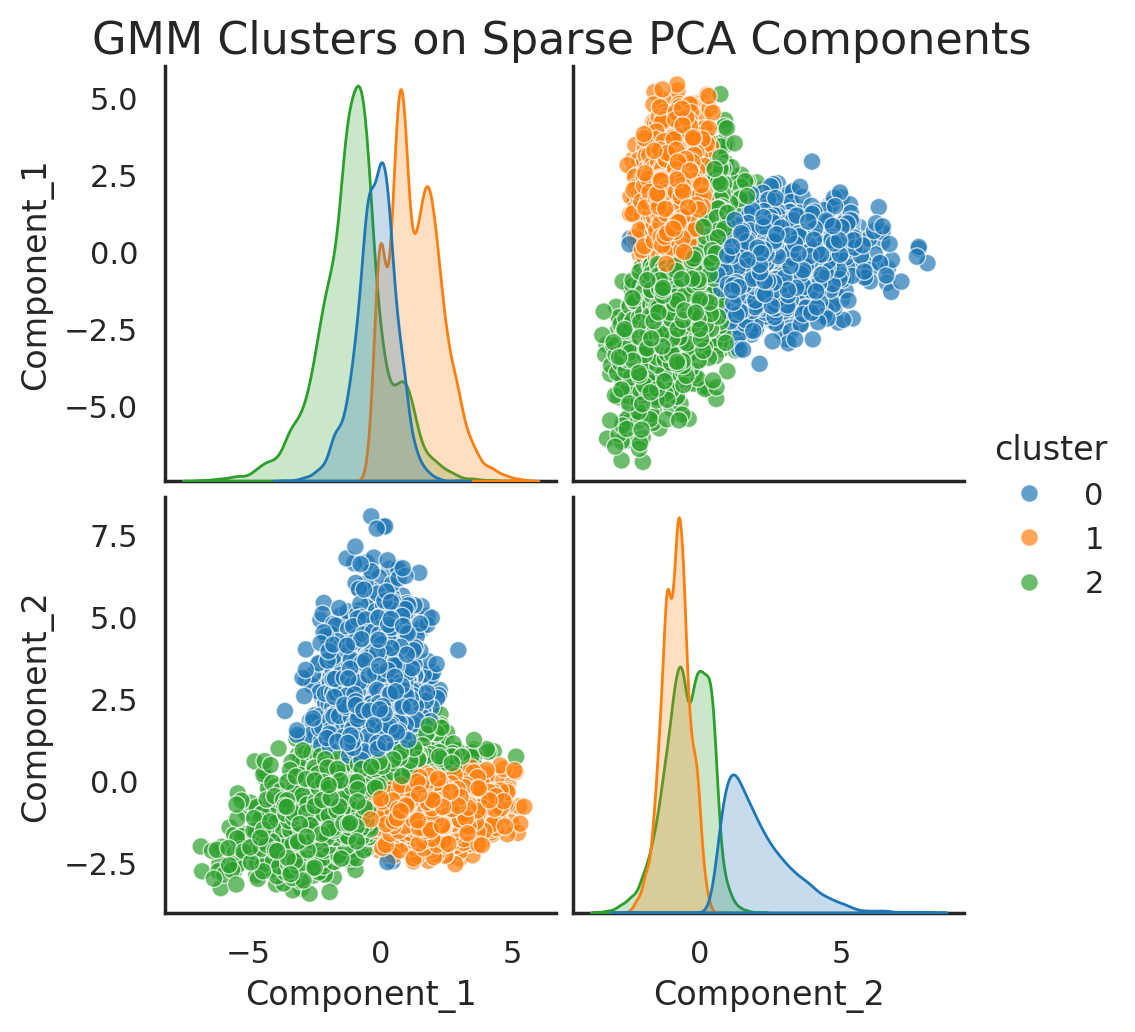

In [10]:
# Pairplot of GMM clusters
sns.pairplot(
    transformed_df,
    vars=[f"Component_{i+1}" for i in range(n_components_spca)],  # Select PCA components
    hue='cluster',
    palette='tab10',
    diag_kind='kde',
    plot_kws={'alpha': 0.7, 's': 40}  # Adjust scatter plot transparency and size
)

# Add a title
plt.suptitle("GMM Clusters on Sparse PCA Components", y=1.02, fontsize=16)

# Show the plot
plt.show()

In [11]:
# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_components_gmm, random_state=0)
gmm_labels = gmm.fit_predict(final_df)

# Add GMM labels to the DataFrame
final_df['cluster'] = gmm_labels

# Save the profiling dictionary
joblib.dump(gmm, 'pickles/spca_gmm.pkl')

['spca_gmm.pkl']

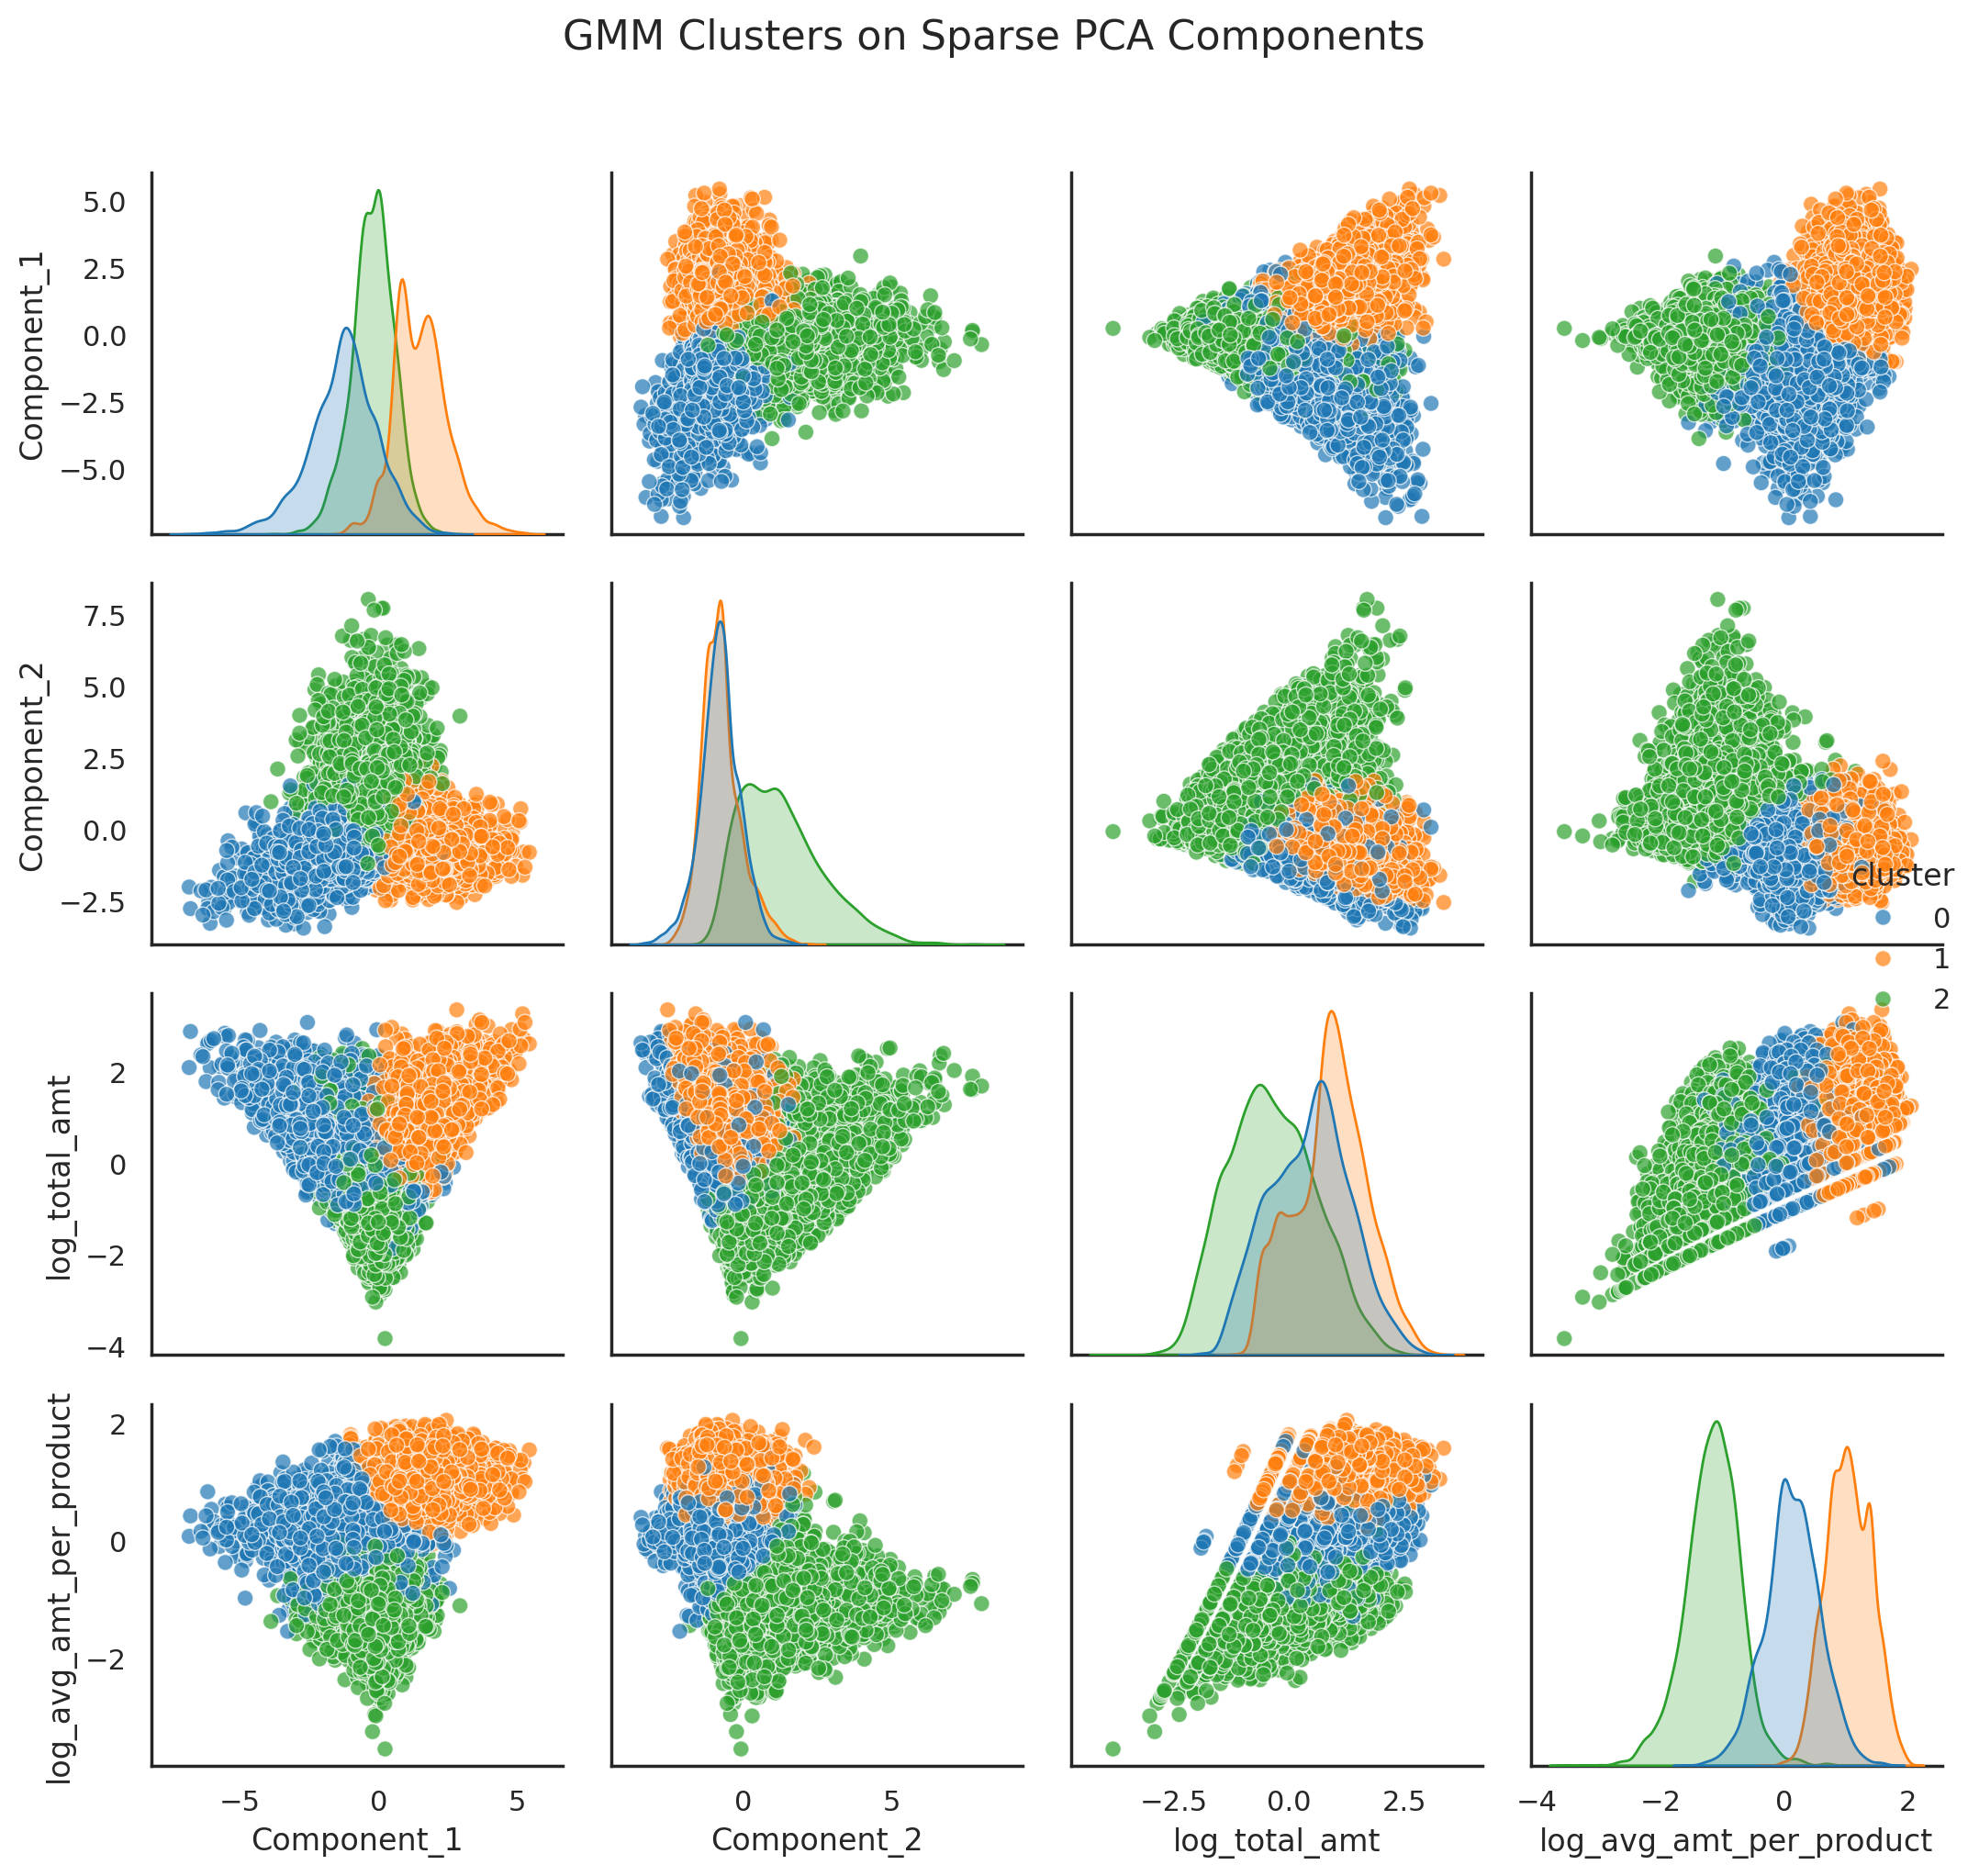

In [12]:
# Pairplot of GMM clusters
sns.pairplot(
    final_df,
    hue='cluster',
    palette='tab10',
    diag_kind='kde',
    plot_kws={'alpha': 0.7, 's': 40},
)

# Add a title
plt.suptitle("GMM Clusters on Sparse PCA Components", y=1.02, fontsize=16)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

plt.savefig('spca_plot.png', format='png')

## Scoring

In [13]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(final_df.drop(columns='cluster'))  # get total sum of squares
ssw_labels = final_df.groupby(by='cluster').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

/tmp/ipykernel_22197/736979065.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ssw_labels = final_df.groupby(by='cluster').apply(get_ss)  # compute ssw for each cluster labels


0.5325529683183245

In [14]:
# Calculate the silhouette score to evaluate clustering
from sklearn.metrics import silhouette_score


silhouette_avg = silhouette_score(final_df.drop(columns='cluster'), final_df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.33581135948027463


## Profiling

In [15]:
# Create dataframe with profiling columns
df_profiling = pd.merge(
    final_df
    ,regulars[
        [col for col in regulars.columns if col.startswith('last_promo_')]
        +[col for col in regulars.columns if col.startswith('pay_method_')]
        +[col for col in regulars.columns if col.startswith('cust_city_')]
        +[col for col in regulars.columns if col.startswith('cust_region_')]
        +[col for col in regulars.columns if col.startswith('age_bucket_')]
    ]
    ,left_index=True
    ,right_index=True
    ,how='left'
)

In [16]:
# Define the columns for each profile
profiling = {
    'Promotion': [col for col in df_profiling.columns if col.startswith('last_promo_')]
    ,'Payment Method': [col for col in df_profiling.columns if col.startswith('pay_method_')]
    ,'City': [col for col in df_profiling.columns if col.startswith('cust_city_')]
    ,'Region': [col for col in df_profiling.columns if col.startswith('cust_region_')]
    ,'Age': [col for col in df_profiling.columns if col.startswith('age_bucket_')]
}

import joblib
# Save the profiling dictionary
joblib.dump(profiling, 'pickles/cuisine_profiling.pkl')

['cuisine_profiling.pkl']

In [45]:
for profile, col in profiling.items():
    cluster_profile = df_profiling.groupby('cluster')[col].mean()

    # Display cluster profiling
    print(f'Cluster Profiling Based on {profile}')
    display(cluster_profile)

Cluster Profiling Based on Promotion


,last_promo_DELIVERY,last_promo_DISCOUNT,last_promo_FREEBIE,last_promo_NO_PROMO
cluster,,,,
0,0.110142,0.123882,0.113413,0.652563
1,0.137284,0.102371,0.157328,0.603017
2,0.159170,0.142647,0.139710,0.558473


Cluster Profiling Based on Payment Method


,pay_method_CARD,pay_method_CASH,pay_method_DIGI
cluster,,,
0,0.743948,0.119084,0.136968
1,0.720259,0.126509,0.153233
2,0.673215,0.136956,0.189829


Cluster Profiling Based on City


,cust_city_2.0,cust_city_4.0,cust_city_8.0
cluster,,,
0,0.102072,0.838168,0.059760
1,0.000216,0.077155,0.922629
2,0.973747,0.025519,0.000734


Cluster Profiling Based on Region


,cust_region_2360.0,cust_region_2400.0,cust_region_4140.0,cust_region_4660.0,cust_region_8370.0,cust_region_8550.0,cust_region_8670.0
cluster,,,,,,,
0,0.085714,0.016358,0.044711,0.793457,0.001527,0.000000,0.058233
1,0.000216,0.000000,0.003664,0.073491,0.030172,0.000647,0.891810
2,0.796769,0.176978,0.002387,0.023132,0.000000,0.000000,0.000734


Cluster Profiling Based on Age


,age_bucket_15-24,age_bucket_25-34,age_bucket_35-44,age_bucket_45-54,age_bucket_55-64,age_bucket_65+
cluster,,,,,,
0,0.392585,0.469793,0.110360,0.021810,0.003708,0.001745
1,0.377155,0.482543,0.108621,0.025000,0.005172,0.001509
2,0.385717,0.476409,0.110152,0.021113,0.005324,0.001285


## Explaining the Clusters

In [46]:
# Load the scaler
scaler = joblib.load('pickles/std_scaler.pkl')

In [47]:
numeric = [
    'cust_age', 'n_vendor', 'n_product', 'n_chain', 'first_order',
    'last_order', 'american', 'asian', 'beverages', 'cafe',
    'chicken_dishes', 'chinese', 'desserts', 'healthy', 'indian', 'italian',
    'japanese', 'noodle_dishes', 'other', 'street_food_snacks', 'thai',
    'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0',
    'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9',
    'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17',
    'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'total_amt',
    'n_order', 'avg_amt_per_product', 'avg_amt_per_order',
    'avg_amt_per_vendor', 'days_cust', 'avg_days_to_order', 'days_due',
    'per_chain_order', 'n_days_week', 'n_times_day', 'n_cuisines',
    'log_n_vendor', 'log_n_product', 'log_n_chain', 'log_american',
    'log_asian', 'log_beverages', 'log_cafe', 'log_chicken_dishes',
    'log_chinese', 'log_desserts', 'log_healthy', 'log_indian',
    'log_italian', 'log_japanese', 'log_noodle_dishes', 'log_other',
    'log_street_food_snacks', 'log_thai', 'log_total_amt', 'log_n_order',
    'log_avg_amt_per_product', 'log_avg_amt_per_order',
    'log_avg_amt_per_vendor', 'log_n_days_week', 'log_n_times_day',
    'avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day'
]

In [48]:
# Revert the scaler
aux_unscaled_df = pd.DataFrame(scaler.inverse_transform(regulars[numeric]), columns=numeric, index=regulars.index)

In [49]:
indices = final_df.index

In [50]:
aux_unscaled_df = aux_unscaled_df.loc[indices]

In [51]:
# Transform the dataset with unscaled values for easier interpretation
for col in ['total_amt', 'n_cuisines', 'n_vendor', 'n_product']:
    final_df[col] = aux_unscaled_df[col]

In [52]:
final_df.groupby('cluster').agg(['min', 'max', 'mean'])

Component_1                     Component_2                      \
                min       max      mean         min       max      mean   
cluster                                                                   
0         -6.814747  2.698660 -1.283069   -3.447263  1.750161 -0.784560   
1         -1.448588  5.430881  1.514407   -2.550054  2.392880 -0.739837   
2         -3.870206  2.933237 -0.210020   -1.806052  8.049988  1.290628   

        log_total_amt                     log_avg_amt_per_product            \
                  min       max      mean                     min       max   
cluster                                                                       
0           -1.917521  3.076378  0.437538               -1.544934  1.694528   
1           -1.190031  3.351394  0.889198               -0.252748  2.053222   
2           -3.825376  2.519026 -0.379897               -3.550892  1.148021   

                  total_amt                    n_cuisines                  \
             mean       min     max       mean        min   max      mean   
cluster                                                                     
0        0.128671      5.77  367.75  55.605394        1.0  10.0  3.079826   
1        1.039881     11.12  458.56  76.626808        1.0   8.0  2.634267   
2       -1.160164      0.47  235.03  30.076580        1.0  11.0  3.788691   

        n_vendor                 n_product                  
             min   max      mean       min   max      mean  
cluster                                                     
0            1.0  24.0  4.141112       1.0  49.0  8.391930  
1            1.0  24.0  4.207328       1.0  41.0  7.323060  
2            1.0  24.0  5.134019       1.0  61.0  8.848357

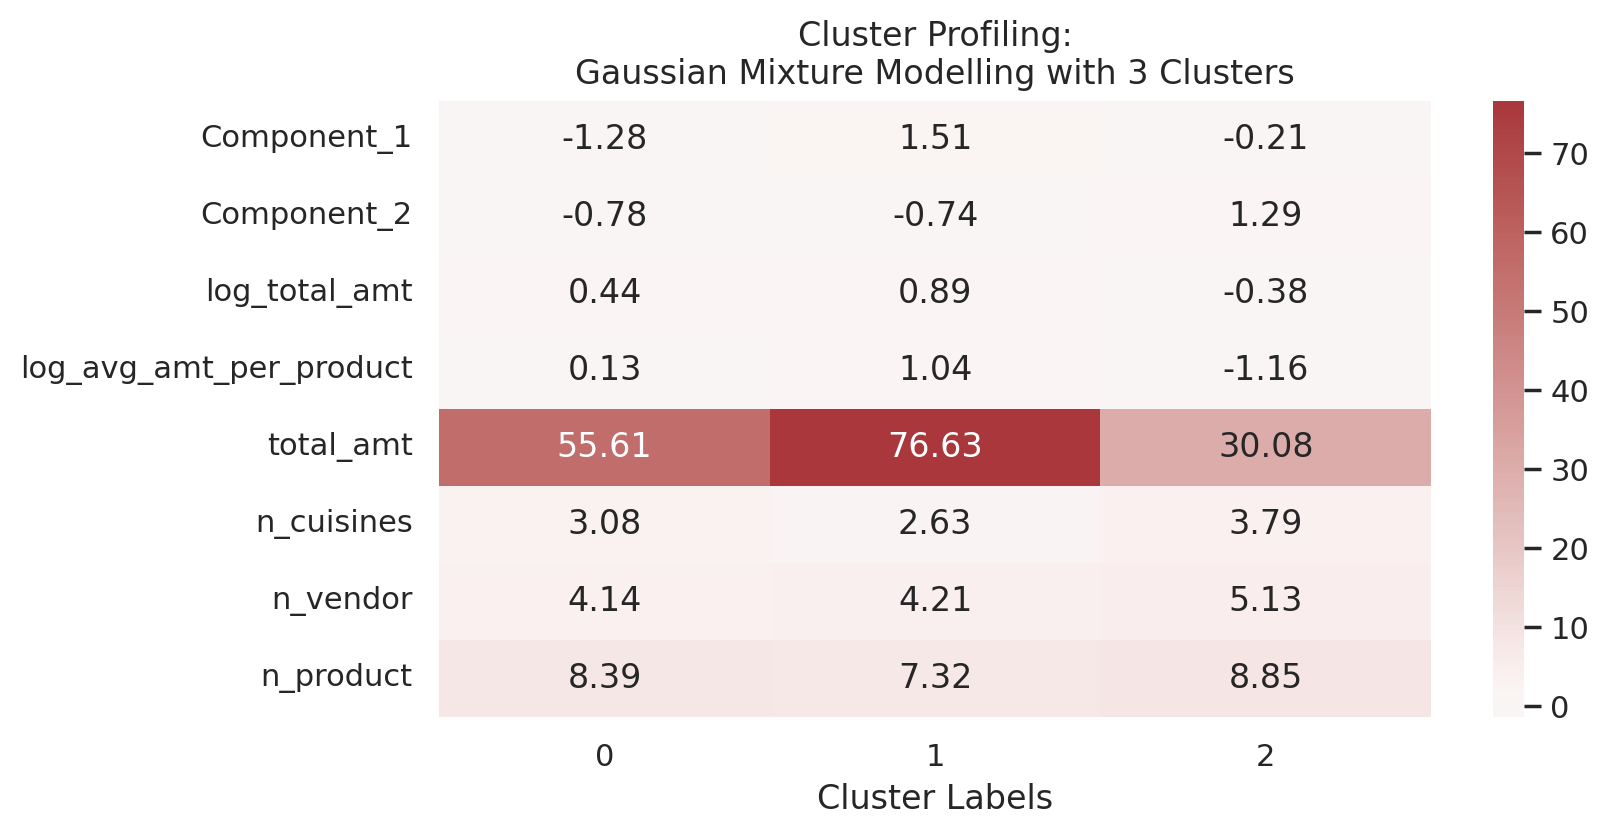

In [53]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = final_df.groupby('cluster').mean().T

sns.heatmap(hc_profile, center=0, annot=True, cmap="vlag", fmt=".2f", ax=ax)

ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling:\nGaussian Mixture Modelling with {n_components_gmm} Clusters")
plt.show()